In [1]:
import os
import time
import argparse
import pickle
import gc
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable,gradcheck
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import shuffle

In [2]:
transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
train_data = datasets.ImageFolder('new_UTKFace/train', transform=transform)
val_data = datasets.ImageFolder('new_UTKFace/validation', transform=transform)
test_data = datasets.ImageFolder('new_UTKFace/test', transform=transform)

In [3]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [4]:
def get_less_restricted_accuracy(model, loader):
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        imgs = torch.from_numpy(imgs.detach().numpy()) 
        output = model(imgs)
        prob = F.softmax(output, dim=1)
        #select index with maximum prediction score
        pred = prob.max(1, keepdim=True)[1]
        
        # changing them for easier "math" later
        for i in range(labels.shape[0]):
            if labels[i] == 3:
                labels[i] = 1
            elif labels[i] == 1:
                labels[i] = 2
            elif labels[i] == 2:
                labels[i] = 3
            
            if pred[i] == 3:
                pred[i] = 1
            elif pred[i] == 1:
                pred[i] = 2
            elif pred[i] == 2:
                pred[i] = 3
        
        for i in range(imgs.shape[0]):
            if abs(pred[i] - labels[i].view_as(pred[i])) <= 1:
                correct += 1
                
        total += imgs.shape[0]
    return correct / total

In [6]:
class SVM(nn.Module):
    def __init__(self,n_feature,n_class): #n_feature=128*128, n_class=4
        super(SVM, self).__init__()
        self.fc=nn.Linear(n_feature,n_class)
        torch.nn.init.kaiming_uniform_(self.fc.weight)
        torch.nn.init.constant_(self.fc.bias,0.1)
        
    def forward(self,x):
        x = x.view(-1, 128*128*3)
        output=self.fc(x)
        return output

In [7]:
"""
SVM loss
Weston and Watkins version multiclass hinge loss @ https://en.wikipedia.org/wiki/Hinge_loss
for each sample, given output (a vector of n_class values) and label y (an int \in [0,n_class-1])
loss = sum_i(max(0, (margin - output[y] + output[i]))^p) where i=0 to n_class-1 and i!=y
Note: hinge loss is not differentiable
      Let's denote hinge loss as h(x)=max(0,1-x). h'(x) does not exist when x=1, 
      because the left and right limits do not converge to the same number, i.e.,
      h'(1-delta)=-1 but h'(1+delta)=0.
      
      To overcome this obstacle, people proposed squared hinge loss h2(x)=max(0,1-x)^2. In this case,
      h2'(1-delta)=h2'(1+delta)=0
"""
class multiClassHingeLoss(nn.Module):
    def __init__(self, p=1, margin=1, weight=None, size_average=True):
        super(multiClassHingeLoss, self).__init__()
        self.p=p
        self.margin=margin
        self.weight=weight #weight for each class, size=n_class, variable containing FloatTensor,cuda,reqiures_grad=False
        self.size_average=size_average
    def forward(self, output, y):#output: batchsize*n_class
        #print(output.requires_grad)
        #print(y.requires_grad)
        output_y=output[torch.arange(0,y.size()[0]).long(),y.data].view(-1,1)#view for transpose
        #margin - output[y] + output[i]
        loss=output-output_y+self.margin#contains i=y
        #remove i=y items
        loss[torch.arange(0,y.size()[0]).long(),y.data]=0
        #max(0,_)
        loss[loss<0]=0
        #^p
        if(self.p!=1):
            loss=torch.pow(loss,self.p)
        #add weight
        if(self.weight is not None):
            loss=loss*self.weight
        #sum up
        loss=torch.sum(loss)
        if(self.size_average):
            loss/=output.size()[0]#output.size()[0]
        return loss

In [8]:
def train(model, batch_size, learning_rate, epochs):
    torch.manual_seed(1000)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=1, shuffle=True)
    criterion = multiClassHingeLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99))
    
    iters, losses, train_acc, val_acc, train_acc_less_restricted, val_acc_less_restricted = [], [], [], [], [], []
    n = 0 # the number of iterations
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            imgs, labels = data
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader)) # compute validation accuracy
        train_acc_less_restricted.append(get_less_restricted_accuracy(model, train_loader)) # compute training accuracy 
        val_acc_less_restricted.append(get_less_restricted_accuracy(model, val_loader)) # compute validation accuracy
        n += 1
        print(("Epoch {}: Train loss: {} |"+
               "Train acc: {}, Validation acc: {} |"+
               "Train acc(less restricted): {}, Validation acc(less restricted): {}").format(
                   epoch + 1,
                   losses[epoch],
                   train_acc[epoch],
                   val_acc[epoch],
                   train_acc_less_restricted[epoch],
                   val_acc_less_restricted[epoch]))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc_less_restricted, label="Train")
    plt.plot(iters, val_acc_less_restricted, label="Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy(less restricted)")
    plt.legend(loc='best')
    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Final Training Accuracy(less restricted): {}".format(train_acc_less_restricted[-1]))
    print("Final Validation Accuracy(less restricted): {}".format(val_acc_less_restricted[-1]))


Epoch 1: Train loss: 4.573821067810059 |Train acc: 0.22149268116378532, Validation acc: 0.21163575042158517 |Train acc(less restricted): 0.5370158424191314, Validation acc(less restricted): 0.5272625070264193
Epoch 2: Train loss: 1.7744011878967285 |Train acc: 0.3699174748509126, Validation acc: 0.35947161326587973 |Train acc(less restricted): 0.6739955424372026, Validation acc(less restricted): 0.6475548060708263
Epoch 3: Train loss: 2.349191665649414 |Train acc: 0.29950003011866755, Validation acc: 0.27431141090500283 |Train acc(less restricted): 0.5552677549545209, Validation acc(less restricted): 0.5354131534569984
Epoch 4: Train loss: 3.7291595935821533 |Train acc: 0.2204686464670803, Validation acc: 0.21304103428892637 |Train acc(less restricted): 0.6139991566773086, Validation acc(less restricted): 0.59584035975267
Epoch 5: Train loss: 1.64487886428833 |Train acc: 0.318775977350762, Validation acc: 0.2942664418212479 |Train acc(less restricted): 0.7625444250346365, Validation ac

Epoch 41: Train loss: 1.8223228454589844 |Train acc: 0.3333534124450334, Validation acc: 0.29398538504777966 |Train acc(less restricted): 0.5590627070658394, Validation acc(less restricted): 0.5418774592467679
Epoch 42: Train loss: 0.45687758922576904 |Train acc: 0.47153785916511054, Validation acc: 0.3732433951658235 |Train acc(less restricted): 0.802240828865731, Validation acc(less restricted): 0.7613827993254637
Epoch 43: Train loss: 0.8598166108131409 |Train acc: 0.4843684115414734, Validation acc: 0.3954468802698145 |Train acc(less restricted): 0.7988675381001145, Validation acc(less restricted): 0.7453625632377741
Epoch 44: Train loss: 1.3520480394363403 |Train acc: 0.442443226311668, Validation acc: 0.3473861720067454 |Train acc(less restricted): 0.731221010782483, Validation acc(less restricted): 0.6824058459808882
Epoch 45: Train loss: 1.1269824504852295 |Train acc: 0.5189446418890429, Validation acc: 0.4319842608206858 |Train acc(less restricted): 0.7905547858562737, Validat

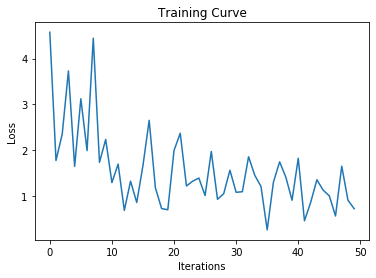

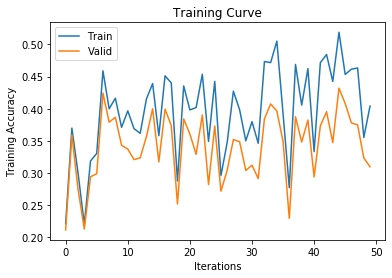

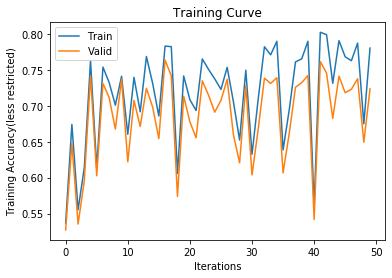

Final Training Accuracy: 0.40413228118788025
Final Validation Accuracy: 0.30972456436200113
Final Training Accuracy(less restricted): 0.780193964219023
Final Validation Accuracy(less restricted): 0.7234401349072512


In [9]:
use_cuda = True
model = SVM(128*128*3, 11)
train(model, 32, 0.005, 50)